In [1]:
from collections import Counter

from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, ClassifierMixin

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris, make_moons, make_circles, make_classification

import keras
from keras.layers import Dense
from keras.optimizers import SGD
from keras.models import Sequential

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
def plot_all(combo_clf_ds):
    row_num = 0
    col_num = 0
    for _, ds in enumerate(combo_clf_ds):
        row_num += 1
        col_num = max(col_num, len(ds['classifiers']))

    iplt = 1
    for ids, ds in enumerate(combo_clf_ds):
        for iclf, clf in enumerate(ds['classifiers']):
            plt.subplot(row_num, col_num, iplt)
            plot_decision_regions(ds['X'], ds['y'], clf)
            #plt.xlabel('Eixo x')
            if iclf == 0: plt.ylabel(ds['name'])
            if ids == 0: plt.title(ds['clf_names'][iclf])
            plt.legend(loc='upper left')
            plt.tight_layout()
            iplt+=1
    
    plt.show()


def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, color=cmap(idx),
                    marker=markers[idx], label=cl)

In [3]:
class RenearMLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_len, epoch = 1000):
        self.hidden_len = hidden_len
        self.epoch = epoch
        pass

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
        
    def fit(self, X, y=None):
        
        alpha = 0.2
        x_len = len(X)
        X = np.array(X)

        input_len = X[0].shape[0]
        output_len = 1 if len(y.shape) == 1 else y[0].shape[0]

        self.w1 = np.random.rand(self.hidden_len, input_len + 1)
        self.w2 = np.random.rand(output_len, self.hidden_len + 1)

        #print('w1: {}, w2: {}'.format(self.w1.shape, self.w2.shape))

        for epoch in range(self.epoch):
            
            self.D1 = np.zeros(self.w1.shape)
            self.D2 = np.zeros(self.w2.shape)

            for idx, _ in enumerate(X):
                h = self.forward_fase([X[idx]])
                self.backward_fase([y[idx]], h)

            self.w1 = self.w1 - (alpha * (self.D1 / x_len))
            self.w2 = self.w2 - (alpha * (self.D2 / x_len))

        return self

    def forward_fase(self, X, y=None):

        X = np.array(X)
        bias = np.ones((X.shape[0], 1))
        self.a1 = np.hstack((bias, X))
        
        z2 = self.a1.dot(self.w1.T)
        x2 = self.sigmoid(z2)
        self.a2 = np.hstack((bias, x2))

        z3 = self.a2.dot(self.w2.T)
        return self.sigmoid(z3)

    def backward_fase(self, y, h):

        d3 = h - y
        d2 = np.multiply(self.w2.T.dot(d3.T), np.multiply(self.a2, 1 - self.a2).T)[1:]

        self.D2 = self.D2 + d3.T.dot(self.a2)
        self.D1 = self.D1 + d2.dot(self.a1)

    def predict(self, X):
        y = self.forward_fase(X)
        
        if y.shape[1] == 1:
            return (y > 0.5).astype(int)
        
        return np.argmax(y, 1)


In [4]:
class KerasMLP(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_len, epoch = 1000):
        self.hidden_len = hidden_len
        self.epoch = epoch
        
    def fit(self, X, y=None):
        
        X = np.array(X)

        input_len = X[0].shape[0]
        output_len = 1 if len(y.shape) == 1 else y[0].shape[0]

        self.model = Sequential()
        self.model.add(Dense(self.hidden_len, input_dim=input_len, activation='sigmoid'))
        self.model.add(Dense(output_len, activation='sigmoid'))

        loss_fcn = 'binary_crossentropy'
        if output_len > 1: loss_fcn = 'categorical_crossentropy'

        sgd = SGD(lr=0.1)
        self.model.compile(loss=loss_fcn, optimizer=sgd, metrics=['accuracy']) 
        self.model.fit(X, y, epochs=self.epoch, batch_size=1, verbose=0)

        return self

    def predict(self, X):
        y = self.model.predict(X)
        
        if y.shape[1] == 1:
            return (y > 0.5).astype(int)
        
        return np.argmax(y, 1)

In [5]:
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

ds1_X = X
ds1_y = y
ds2_X, ds2_y = make_moons(noise=0.3, random_state=0)
ds3_X, ds3_y = make_circles(noise=0.2, factor=0.5, random_state=1)

In [6]:
ds1_renear = RenearMLP(10, 10000).fit(ds1_X, ds1_y)
ds2_renear = RenearMLP(10, 10000).fit(ds2_X, ds2_y)
ds3_renear = RenearMLP(10, 10000).fit(ds3_X, ds3_y)

ds1_keras = KerasMLP(10, 1000).fit(ds1_X, ds1_y)
ds2_keras = KerasMLP(10, 1000).fit(ds2_X, ds2_y)
ds3_keras = KerasMLP(10, 1000).fit(ds3_X, ds3_y)

ds1_sklearn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000).fit(ds1_X, ds1_y)
ds2_sklearn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000).fit(ds2_X, ds2_y)
ds3_sklearn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000).fit(ds3_X, ds3_y)

Resultado de score de cada classificador em cada base

In [7]:
print('Bade 1 (Linearmente separável)')
print('RenearMLP: {}'.format(ds1_renear.score(ds1_X, ds1_y)))
print('KerasMLP: {}'.format(ds1_keras.score(ds1_X, ds1_y)))
print('MLPClassifier: {}'.format(ds1_sklearn.score(ds1_X, ds1_y)))
print('')
print('Bade 2 (Moons)')
print('RenearMLP: {}'.format(ds2_renear.score(ds2_X, ds2_y)))
print('KerasMLP: {}'.format(ds2_keras.score(ds2_X, ds2_y)))
print('MLPClassifier: {}'.format(ds2_sklearn.score(ds2_X, ds2_y)))
print('')
print('Bade 3 (Circles)')
print('RenearMLP: {}'.format(ds3_renear.score(ds3_X, ds3_y)))
print('KerasMLP: {}'.format(ds3_keras.score(ds3_X, ds3_y)))
print('MLPClassifier: {}'.format(ds3_sklearn.score(ds3_X, ds3_y)))

Bade 1 (Linearmente separável)
RenearMLP: 0.96
KerasMLP: 0.96
MLPClassifier: 0.96

Bade 2 (Moons)
RenearMLP: 0.95
KerasMLP: 0.97
MLPClassifier: 0.89

Bade 3 (Circles)
RenearMLP: 0.91
KerasMLP: 0.94
MLPClassifier: 0.9


Separação das bases realizadas pelos classificadores

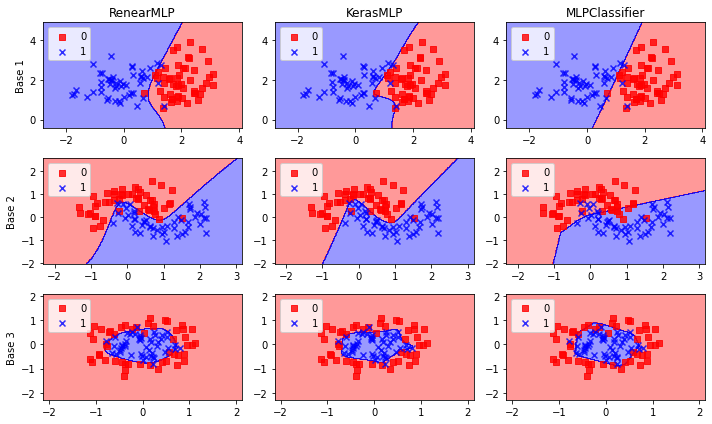

In [8]:
combo = [{
      'X': ds1_X, 
      'y': ds1_y,
      'name': 'Base 1',
      'classifiers': [ds1_renear, ds1_keras, ds1_sklearn],
      'clf_names': ['RenearMLP', 'KerasMLP', 'MLPClassifier'],
    },{
      'X': ds2_X, 
      'y': ds2_y,
      'name': 'Base 2',
      'classifiers': [ds2_renear, ds2_keras, ds2_sklearn],
    },{
      'X': ds3_X, 
      'y': ds3_y,
      'name': 'Base 3',
      'classifiers': [ds3_renear, ds3_keras, ds3_sklearn],
    }]

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plot_all(combo)

In [9]:
xor_data = np.array([
    [0, 0, 0],
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

xor_X = xor_data[:, 0:2]
xor_y = xor_data[:, 2]

iris_data = load_iris()
iris_X, iris_y = iris_data.data, iris_data.target
iris_X = PCA(n_components=2).fit_transform(iris_X)

onehot_encoder = OneHotEncoder(sparse=False)
reshaped= iris_y.reshape(len(iris_y), 1)
iris_onehot_y = onehot_encoder.fit_transform(reshaped)

In [10]:
xor_renear = RenearMLP(5, 10000).fit(xor_X, xor_y)
iris_renear = RenearMLP(5, 1000).fit(iris_X, iris_onehot_y)

xor_keras = KerasMLP(8, 1000).fit(xor_X, xor_y)
iris_keras = KerasMLP(5, 250).fit(iris_X, iris_onehot_y)

xor_sklearn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000).fit(xor_X, xor_y)
iris_sklearn = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000).fit(iris_X, iris_y)

Resultado de score de cada classificador em cada base

In [11]:
print('XOR')
print('RenearMLP: {}'.format(xor_renear.score(xor_X, xor_y)))
print('KerasMLP: {}'.format(xor_keras.score(xor_X, xor_y)))
print('MLPClassifier: {}'.format(xor_sklearn.score(xor_X, xor_y)))
print('')
print('Iris Flower')
print('RenearMLP: {}'.format(iris_renear.score(iris_X, iris_y)))
print('KerasMLP: {}'.format(iris_keras.score(iris_X, iris_y)))
print('MLPClassifier: {}'.format(iris_sklearn.score(iris_X, iris_y)))

XOR
RenearMLP: 1.0
KerasMLP: 1.0
MLPClassifier: 1.0

Iris Flower
RenearMLP: 0.9666666666666667
KerasMLP: 0.9733333333333334
MLPClassifier: 0.9666666666666667


Separação das bases realizadas pelos classificadores

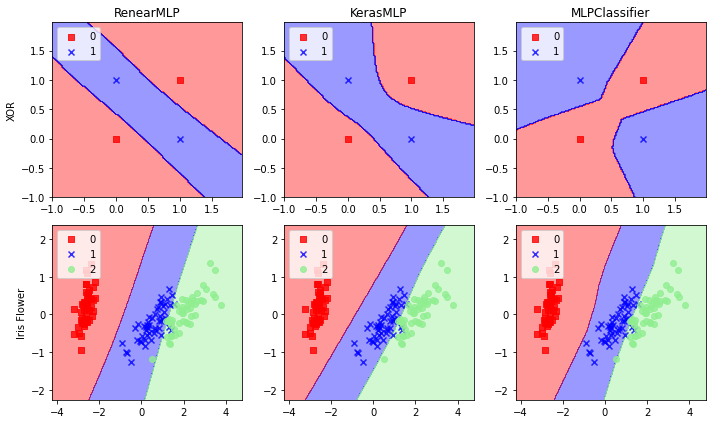

In [12]:
combo = [{
      'X': xor_X, 
      'y': xor_y,
      'name': 'XOR',
      'classifiers': [xor_renear, xor_keras, xor_sklearn],
      'clf_names': ['RenearMLP', 'KerasMLP', 'MLPClassifier'],
    },{
      'X': iris_X,
      'y': iris_y,
      'name': 'Iris Flower',
      'classifiers': [iris_renear, iris_keras, iris_sklearn],
    }]

plt.rcParams['figure.figsize'] = [10.0, 6.0]
plot_all(combo)